## Classification part 2

In [2]:
# Import main packages
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from skimage.color import rgb2hsv
from skimage.morphology import closing, opening, disk
from skimage import io
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [3]:
# Define paths
neutral_path = os.path.join("C:/Users/rapha/OneDrive/Documents/2. EPFL/Master/MA2/Image Analysis & Pattern Recognition/iapr24-coin-counter/train/1. neutral_bg", "L1010277.jpg")
noisy_path = os.path.join("C:/Users/rapha/OneDrive/Documents/2. EPFL/Master/MA2/Image Analysis & Pattern Recognition/iapr24-coin-counter/train/2. noisy_bg", "L1010325.jpg")
hand_path = os.path.join("C:/Users/rapha/OneDrive/Documents/2. EPFL/Master/MA2/Image Analysis & Pattern Recognition/iapr24-coin-counter/train/3. hand", "L1010373.jpg")

neutral_folder = os.path.join("C:/Users/rapha/OneDrive/Documents/2. EPFL/Master/MA2/Image Analysis & Pattern Recognition/iapr24-coin-counter/train/1. neutral_bg")
noisy_folder = os.path.join("C:/Users/rapha/OneDrive/Documents/2. EPFL/Master/MA2/Image Analysis & Pattern Recognition/iapr24-coin-counter/train/2. noisy_bg")
hand_folder = os.path.join("C:/Users/rapha/OneDrive/Documents/2. EPFL/Master/MA2/Image Analysis & Pattern Recognition/iapr24-coin-counter/train/3. hand")

neutral_test_folder = os.path.join("C:/Users/rapha/OneDrive/Documents/2. EPFL/Master/MA2/Image Analysis & Pattern Recognition/iapr24-coin-counter/combined_folders/Neutral")
noisy_test_folder = os.path.join("C:/Users/rapha/OneDrive/Documents/2. EPFL/Master/MA2/Image Analysis & Pattern Recognition/iapr24-coin-counter/combined_folders/Noisy")
hand_test_folder = os.path.join("C:/Users/rapha/OneDrive/Documents/2. EPFL/Master/MA2/Image Analysis & Pattern Recognition/iapr24-coin-counter/combined_folders/Hand")

## Classify CHF

Goal: for each crop of CHF coin, classify into CHF subclass 

- Considère chaque pièce une à une indépendament de l'image de laquelle elle vient
- Classifier sur l'aire/périmètre (nombre de pixels) et la couleur

We use the segmentation function (here from neutral images) to obtain the circles from the segmented coins

In [4]:
def detect_and_display_circles_neutral(image_path, display=False):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        print("Error: Image not found at", image_path)
        return None

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur
    blur = cv2.GaussianBlur(gray, (9, 9), 2)

    # Apply adaptive thresholding and morphological operations
    img_th = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 11, 2)
    kernel = np.ones((7, 7), np.uint8)
    closing = cv2.morphologyEx(img_th, cv2.MORPH_CLOSE, kernel)
    closing = cv2.dilate(closing, kernel, iterations=3)

    # Hough Circle Transform
    circles = cv2.HoughCircles(closing, cv2.HOUGH_GRADIENT, dp=1, minDist=100, 
                               param1=50, param2=10, minRadius=50, maxRadius=120)

    if display:
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if circles is not None:
            circles_ = np.uint16(np.around(circles))[0, :]
            for (x, y, r) in circles_:
                plt.gca().add_patch(plt.Circle((x, y), r, color='red', fill=False, linewidth=2))
        plt.title('Detected Circles in ' + os.path.basename(image_path))
        plt.axis('off')
        plt.show()
    
    if circles is not None:
        return [(x, y, r) for (x, y, r) in np.uint16(np.around(circles))[0, :]]
    else:
        return []

def crop_coins(image, circles):
    cropped_images = []
    for (x, y, r) in circles:
        x, y, r = int(x), int(y), int(r)
        cropped_img = image[y-r:y+r, x-r:x+r]
        cropped_images.append(cropped_img)
    return cropped_images

def detect_and_crop_coins(image_path, image_type, display_cropped=False):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        print("Error: Image not found at", image_path)
        return None

    # Call the appropriate detection function
    if image_type == 'neutral':
        circles = detect_and_display_circles_neutral(image_path, display=False)
    #elif image_type == 'hand':
    #    circles = detect_and_display_circles_hand(image_path, display=False)
    else:
        print("Error: Unknown image type")
        return None

    if not circles:
        print("No circles detected")
        return []

    # Crop the detected coins
    cropped_images = crop_coins(img, circles)

    # Display cropped images if required
    if display_cropped:
        for i, cropped_img in enumerate(cropped_images):
            plt.figure(figsize=(4, 4))
            plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
            plt.title(f'Cropped Coin {i+1}')
            plt.axis('off')
            plt.show()

    return cropped_images, circles

#### Downsample

We work on downsampled images, make sure to use downsampled images

In [29]:
import os
from PIL import Image

def downsample_images(file_path, save_path, size=(1500, 1000)):
    im = Image.open(file_path)
    downsampled_image = im.resize(size)  # Specify desired width and height

    # Create the save directory if it does not exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # Construct the save path for the downsampled image
    filename = os.path.basename(file_path)
    downsampled_image_save_path = os.path.join(save_path, filename)
    
    # Save the downsampled image
    downsampled_image.save(downsampled_image_save_path)

def downsample_images_in_directory(input_directory, output_directory, size=(1500, 1000)):
    # List all JPG images in the directory
    images = glob.glob(os.path.join(input_directory, '*.JPG'))
    
    for image_path in images:
        downsample_images(image_path, output_directory, size)
        print(f"Processed and saved: {os.path.basename(image_path)}")


Processed and saved: L1010277.JPG
Processed and saved: L1010279.JPG
Processed and saved: L1010281.JPG
Processed and saved: L1010283.JPG
Processed and saved: L1010287.JPG
Processed and saved: L1010288.JPG
Processed and saved: L1010294.JPG
Processed and saved: L1010297.JPG
Processed and saved: L1010298.JPG
Processed and saved: L1010300.JPG
Processed and saved: L1010308.JPG
Processed and saved: L1010310.JPG
Processed and saved: L1010311.JPG
Processed and saved: L1010318.JPG
Processed and saved: L1010321.JPG
Processed and saved: L1010323.JPG


In [ ]:

# Example usage
input_directory = "C:/Users/rapha/OneDrive/Documents/2. EPFL/Master/MA2/Image Analysis & Pattern Recognition/iapr24-coin-counter/train/1. neutral_bg"
output_directory = "C:/Users/rapha/OneDrive/Documents/2. EPFL/Master/MA2/Image Analysis & Pattern Recognition/iapr24-coin-counter/train_neutralbg_ downsampled"
downsample_images_in_directory(input_directory, output_directory)


In [6]:
cropped_images, circles = detect_and_crop_coins("C:/Users/rapha/OneDrive/Documents/2. EPFL/Master/MA2/Image Analysis & Pattern Recognition/iapr24-coin-counter/ref/_resized.JPG", 'neutral')

## Compute features

Each detected circle is represented by three values: the x-coordinate of the center, the y-coordinate of the center, and the radius

In [7]:
import numpy as np
import pandas as pd 

def calculate_circle_properties(circles):
    """
    Calculate the perimeter and area of circles from the given circles array.

    Parameters:
    circles (numpy array): Array of detected circles with shape (1, N, 3), where each circle is represented by (x, y, radius).

    Returns:
    list of tuples: Each tuple contains (perimeter, area) for each circle.
    """
    if circles is None:
        return []
    
    properties = []
    
    for (x, y, r) in circles:
        perimeter = 2 * np.pi * r
        area = np.pi * r ** 2
        properties.append((perimeter, area))
    
    return properties

# Assume `circles` is already defined and contains the detected circles
properties = calculate_circle_properties(circles)

# Creating a DataFrame
labels_ref_image = ["five_back", "five_front", "two_front", "one_back", "two_back", "twenty_back", "twenty_front", "one_front", "fifty_back", "five_cents_back", "fifty_front", "ten_back", "ten_front", "five_cents_front"]
df = pd.DataFrame(properties, columns=['Perimeter', 'Area'], index=labels_ref_image)
df

,Perimeter,Area
five_back,653.451272,33979.466141
five_front,647.168087,33329.156462
two_front,584.336234,27171.634861
one_back,508.938010,20611.989400
two_back,590.619419,27759.112687
twenty_back,471.238898,17671.458676
twenty_front,471.238898,17671.458676
one_front,496.371639,19606.679751
fifty_back,414.690230,13684.777599
five_cents_back,402.123860,12867.963509


## Thresholds

Perim: 600, 550, 480, 450, 420, 410
Area: 30000, 2500, 1800, 1600, 1400, 1300

five:
- perimeter: 647-653
- area: 33329-33979
Perimeter > 600
Area > 30000

two:
- perimeter: 584-590
- area: 27171-27759
Perimeter < 600 & > 550
Area < 30000 & > 2500

one:
- perimeter: 496-508
- area: 19606-20611
Perimeter < 550 & > 480
Area < 2500 & > 1800

twenty:
- perimeter: 471
- area: 17671
Perimeter < 480 & > 450
Area < 1800 & > 1600

ten:
- perimeter: 433
- area: 14957
Perimeter < 450 & > 420
Area < 

fifty: 
- perimeter: 414
- area: 13684

five_cents:
- perimeter: 389-402
- area: 12076-12868

## Folder

Iterate over whole folder of neutral images: 
- compute perimeter and area, plot mean/min/max to see if can obtain threshold

In [13]:
def process_images_in_directory(directory_path, image_type, display_cropped=False):
    if image_type == 'neutral':
        detect_and_display_circles = detect_and_display_circles_neutral
    else:
        print("Error: Unknown image type")
        return

    # Initialize lists to store perimeters and areas
    perimeters_list = []
    areas_list = []

    # List all jpg images in the directory
    images = glob.glob(os.path.join(directory_path, '*.JPG'))
    for image_path in images:
        circles = detect_and_display_circles(image_path, display=False)
        if circles:
            print(f"Detected circles in {os.path.basename(image_path)}: {circles}")
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)
            cropped_images = crop_coins(img, circles)

            # Return table of perimeter and area of circles found in the image
            properties = calculate_circle_properties(circles)

            # Append the properties to the lists
            for perimeter, area in properties:
                perimeters_list.append(perimeter)
                areas_list.append(area)

            if display_cropped:
                for i, cropped_img in enumerate(cropped_images):
                    plt.figure(figsize=(4, 4))
                    plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
                    plt.title(f'Cropped Coin {i+1}')
                    plt.axis('off')
                    plt.show()
        else:
            print(f"No circles detected in {os.path.basename(image_path)}")

    return perimeters_list, areas_list

Detected circles in L1010279.JPG: [(822, 544, 93), (576, 470, 75), (384, 580, 65), (550, 732, 68)]


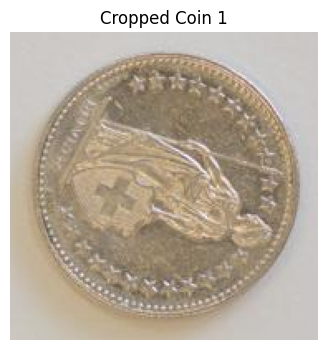

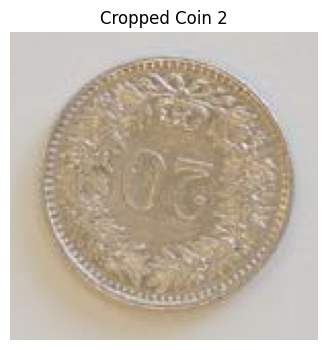

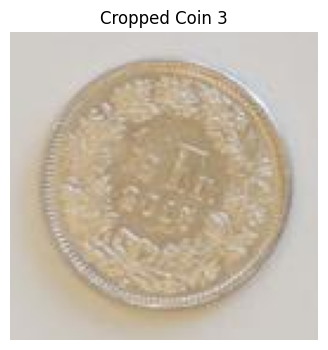

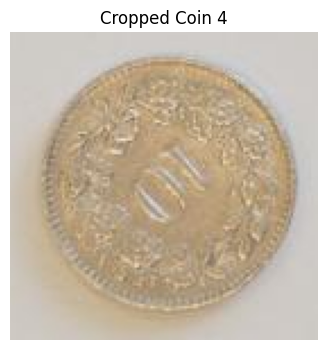

Detected circles in L1010298.JPG: [(668, 376, 93), (594, 622, 92), (788, 800, 80), (906, 372, 66), (940, 578, 66)]


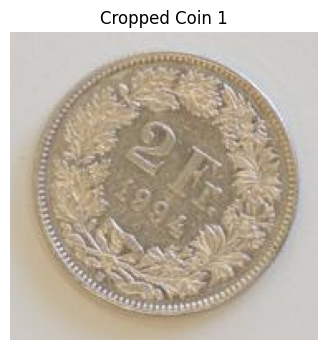

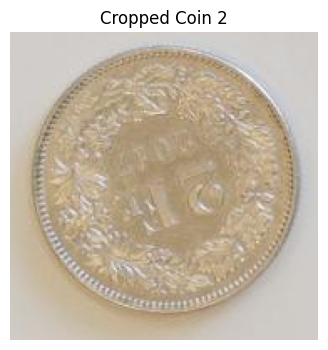

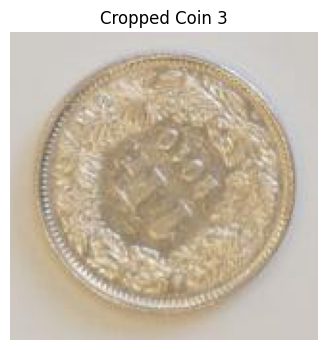

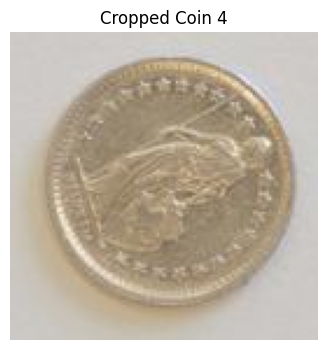

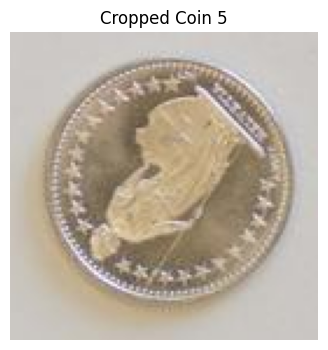

In [17]:
subtest = "C:/Users/rapha/OneDrive/Documents/2. EPFL/Master/MA2/Image Analysis & Pattern Recognition/iapr24-coin-counter/subtest_chf_downsampled"
perimeters_list, areas_list = process_images_in_directory(subtest, 'neutral', display_cropped=True)

## Plot features

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_perimeter_area(labels_, perimeters_list, areas_list):
    # Assuming that the length of perimeters_list and areas_list matches the length of labels_
    data = {
        'Label': labels_,
        'Perimeter': perimeters_list,
        'Area': areas_list
    }

    df = pd.DataFrame(data)

    # Filter out "e" and "ood" labels
    df = df[~df['Label'].isin(['e', 'ood'])]

    # Calculate mean, min, max for each label
    grouped = df.groupby('Label').agg({
        'Perimeter': ['mean', 'min', 'max'],
        'Area': ['mean', 'min', 'max']
    }).reset_index()

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # Plot Perimeter statistics
    grouped_perimeter = grouped['Perimeter']
    labels = grouped['Label']

    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars

    axes[0].bar(x - width, grouped_perimeter['mean'], width, label='Mean')
    axes[0].bar(x, grouped_perimeter['min'], width, label='Min')
    axes[0].bar(x + width, grouped_perimeter['max'], width, label='Max')

    axes[0].set_ylabel('Perimeter')
    axes[0].set_title('Perimeter statistics by class')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(labels)
    axes[0].legend()

    # Add dotted lines for Perimeter
    perim_values = [600, 550, 480, 450, 420, 410]
    for value in perim_values:
        axes[0].axhline(y=value, color='b', linestyle=':', label=f'Perim: {value}')
    
    # Plot Area statistics
    grouped_area = grouped['Area']

    axes[1].bar(x - width, grouped_area['mean'], width, label='Mean')
    axes[1].bar(x, grouped_area['min'], width, label='Min')
    axes[1].bar(x + width, grouped_area['max'], width, label='Max')

    axes[1].set_ylabel('Area')
    axes[1].set_title('Area statistics by class')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(labels)
    axes[1].legend()

    # Add dotted lines for Area
    area_values = [30000, 25000, 18000, 16000, 14000, 13000]
    for value in area_values:
        axes[1].axhline(y=value, color='b', linestyle=':', label=f'Area: {value}')

    plt.tight_layout()
    plt.show()

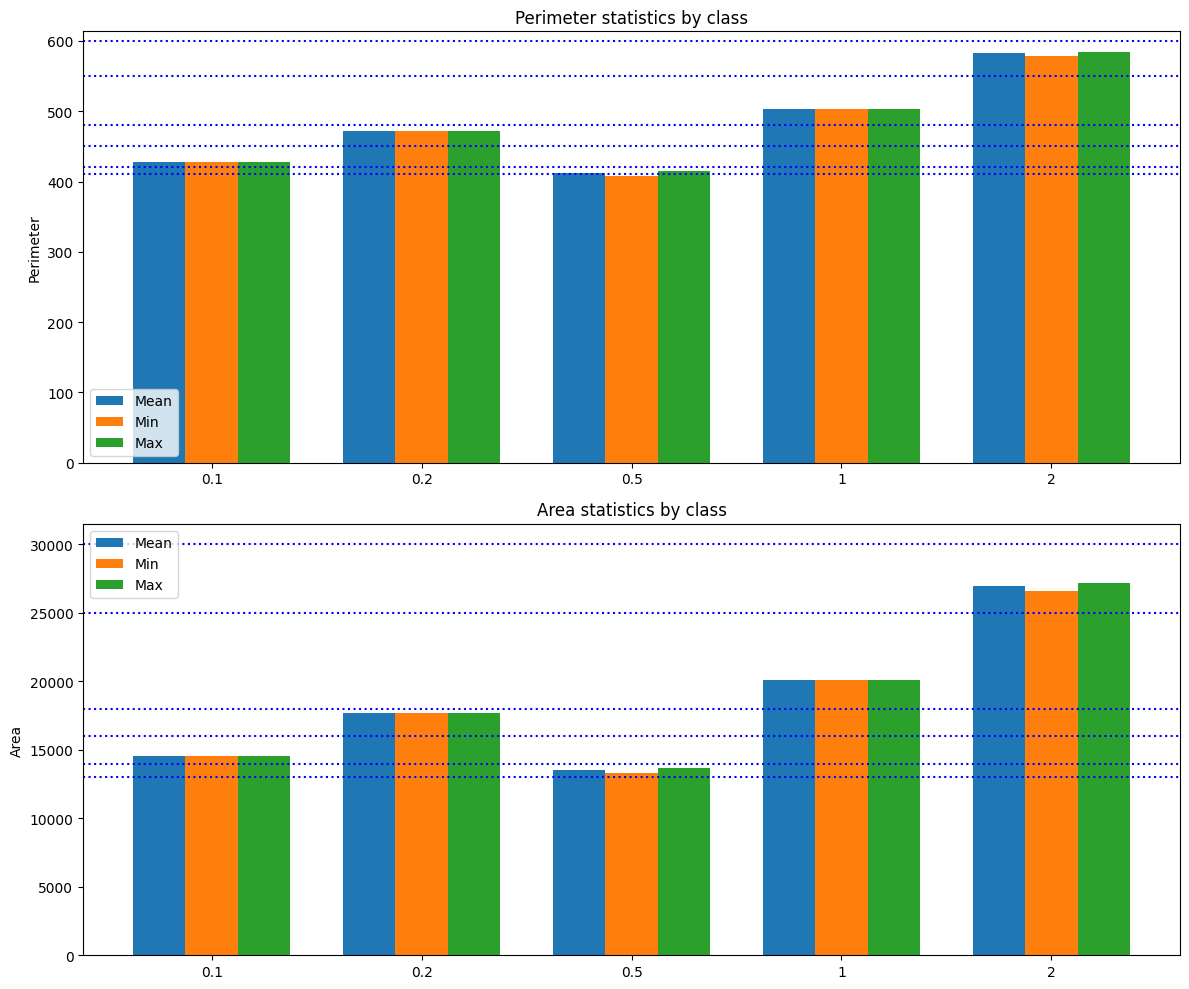

In [18]:
# Example usage 
labels_subtest = ["2", "0.2", "0.5", "0.1", "2", "2", "1", "0.5", "0.5"]

plot_perimeter_area(labels_subtest, perimeters_list, areas_list)

## Classify

Now that we checked the approximative thresholds of a subset of train images, can create a classifier with these thresholds and apply on train set

We don't have the individual labels of the train set !

Classifier:
- separate 5, 2, 1 using area
- separate 5 by color
- separate 20, 10, 50 using perim and area again (try)

In [19]:
def classify_area(area):
    if area > 30000:
        return 5
    elif area > 25000:
        return 2
    elif area > 18000:
        return 1
    elif area > 16000:
        return 0.2
    elif area > 14000:
        return 0.1
    elif area > 13000:
        return 0.5
    else:
        return 0.05


Here we need to classify in EUR or CHF before applying (these images contain both for now)

In [26]:
subtest = "C:/Users/rapha/OneDrive/Documents/2. EPFL/Master/MA2/Image Analysis & Pattern Recognition/iapr24-coin-counter/subtest_chf_downsampled"
perimeters_list, areas_list = process_images_in_directory(subtest, 'neutral')

# True labels
true_labels = ["2", "0.2", "0.5", "0.1", "2", "2", "1", "0.5", "0.5"]

# Classified labels
classified_labels = [classify_area(area) for area in areas_list]

# Compute accuracy
accuracy = sum(1 for true_label, classified_label in zip(true_labels, classified_labels) if true_label == str(classified_label)) / len(true_labels)

print(f"Accuracy: {accuracy * 100:.2f}%")


Detected circles in L1010279.JPG: [(822, 544, 93), (576, 470, 75), (384, 580, 65), (550, 732, 68)]
Detected circles in L1010298.JPG: [(668, 376, 93), (594, 622, 92), (788, 800, 80), (906, 372, 66), (940, 578, 66)]
Accuracy: 100.00%


## Classifier CHF/EUR/OOD

In [1]:
import cv2
import pandas as pd
import torch
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import random
from model import *
from data_processing import *
from utils import *
from segmentation import *
from classify_background import *

%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
original_train_path = './data/train/'
original_test_path = './data/test/'
train_path = './preprocessed_data/downsampled/train/'
test_path = './preprocessed_data/downsampled/test/'
cropped_path = './data/cropped/train/'

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

c:\Users\rapha\anaconda3\envs\iapr\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load test data + detect background
neutral_images = []
neutral_ids = []
noisy_images = []
noisy_ids = []
hand_images = []
hand_ids = []

model = torchvision.models.alexnet(weights='IMAGENET1K_V1')

model.load_state_dict(torch.load("C:/Users/rapha/OneDrive/Documents/2. EPFL/Master/MA2/Image Analysis & Pattern Recognition/iapr_group_55/project/classifier_class3_b6_lr5e4_step7_epoch17_split0.75"))
model.eval()
#TODO: when background on downsamples -> use it here
for root, dirs, files in os.walk("C:/Users/rapha/OneDrive/Documents/2. EPFL/Master/MA2/Image Analysis & Pattern Recognition/iapr24-coin-counter/train_neutralbg_ downsampled"):
#for root, dirs, files in os.walk('./data/test'):
    for file in files:
        if file.endswith('.JPG'):
            # construct path to the image file
            
            file_path = os.path.join(root, file)
            im = cv2.imread(file_path, cv2.IMREAD_COLOR)
            img_id = file[:-4]
            #background = classify_background(im) # TODO: ADD THIS FUNCTION
            background = 'neutral'
            if background == 'neutral':
                neutral_images.append(im)
                neutral_ids.append(img_id)
            elif background == 'noisy':
                noisy_images.append(im)
                noisy_ids.append(img_id)
            elif background == 'hand':
                hand_images.append(im)
                hand_ids.append(img_id)

TypeError: __init__() got an unexpected keyword argument 'weights'

In [ ]:
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize to match model's input size
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize pixel values, based on imagenet
])

In [ ]:
predictions = {}
test = []
model.eval()
for i, img in enumerate(neutral_images):
    outputs = []
    print('Processing image ', i)
    cropped_images = detect_and_crop_coins(np.array(img), 'neutral', display_cropped=False) # returns a list of coins images
    # TODO: here have np.zeros(16) instead
    pred = np.zeros(3)
    if len(cropped_images) != 0:
        for coin in cropped_images:
            coin = preprocess(coin)
            coin = coin.unsqueeze(0)
            with torch.no_grad():
                outputs = model(coin)
            output = torch.argmax(outputs) # index 0 -> CHF, index 1 -> EUR, index 2 -> OOD
            #TODO: here add prediction of how much the coin is
            pred[output] += 1 # add the coin to the image prediction
    else:
        print(f'no coins detected in image {i}')

    predictions[neutral_ids[i]] = pred